# Projet detection des transactions frauduleuses

:Nom des etudiants : *Mariame Sas CONTE 218254: et Oumar Alpha yaya CISSE 218015*



## Exploration des données

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b4d1f95d426f0cc5e68639e1b51354306458b7afad2f36d6d9cb39abefead959
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Importation des bibliotheques
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.sql import functions as F
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Detection de fraude') \
                    .getOrCreate()

In [ ]:
#Importation de la base de donnees
df = spark.read.csv('creditcard.csv',
                         sep=',',
                         header=True, inferSchema =True)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/creditcard.csv.

In [ ]:
#Voir les 5 premieres lignes du dataframe
df.limit(5).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df = df.toPandas()

In [ ]:
#Apercu des 5 dernieres lignes
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
45641,42436,-2.481639,-2.439949,0.363642,1.216827,2.572442,-1.264220,-0.443652,0.075853,0.073188,...,-0.039426,0.480591,1.779358,-0.756700,-0.161099,0.685617,0.223071,0.139619,0.00,0
45642,42436,1.223475,0.014944,0.471312,-0.038410,-0.566793,-0.867970,-0.058213,-0.144080,0.164904,...,-0.053292,-0.093680,0.106348,0.471407,0.135555,0.968336,-0.065171,0.005184,7.49,0
45643,42436,1.258657,0.421016,0.325437,0.684259,-0.292529,-1.052786,0.145228,-0.253567,-0.100521,...,-0.278029,-0.757417,0.119613,0.369393,0.246145,0.091553,-0.017156,0.032557,0.89,0
45644,42437,-0.500147,1.000770,1.809639,-0.114551,0.333865,-0.577076,1.062325,-0.513050,-0.048285,...,-0.193814,-0.161410,0.036965,0.400154,-0.802486,-0.076097,-0.214317,-0.229160,2.69,0
45645,42437,-0.652459,0.177290,1.955607,-1.879724,-0.368457,-0.575021,0.532398,-0.356749,-0.962237,...,-0.531785,-0.582165,0.037794,0.331240,-0.472601,0.652403,0.089295,-0.226742,20.00,0


In [ ]:
#les dimensions de la base
print(f"Nombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

Nombre de lignes: 45646
Nombre de colonnes: 31


In [ ]:
#Definition d une fonction d'affichage
def pourcentage(valeur):
    return "{:.1f}%".format(valeur)

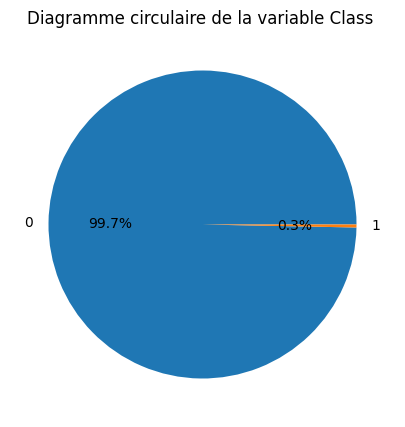

In [ ]:
#variable class
plt.figure(figsize= (8 ,5 ))
#pour creer un diagramme circulaire
plt.pie(df['Class'].value_counts(),
    labels=df['Class'].value_counts().index,
    autopct= pourcentage )
plt.title ('Diagramme circulaire de la variable Class ')

plt.show()

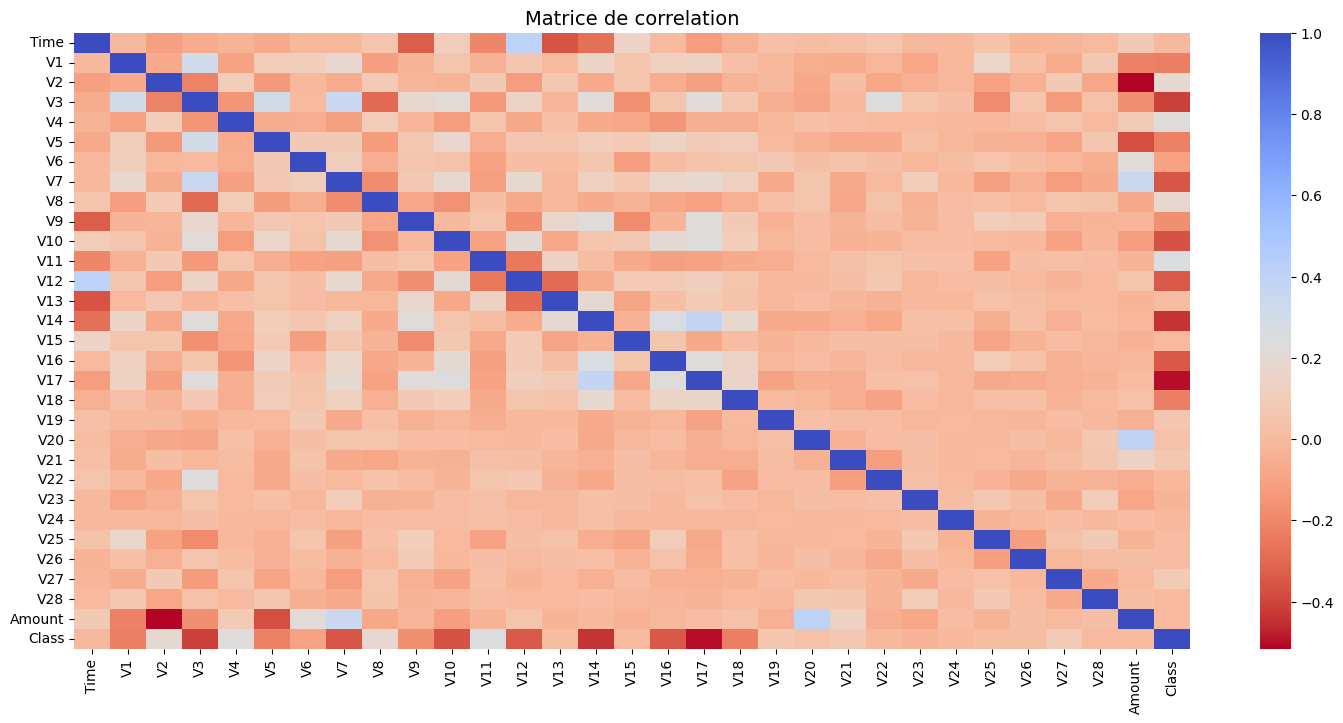

In [ ]:
#Correlation entre les variables
f, ax = plt.subplots(figsize=(18,8))

sub_sample_corr = df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Matrice de correlation', fontsize=14)
plt.show()

In [ ]:
#type de variable de la base
df.dtypes

Time        int32
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int32
dtype: object

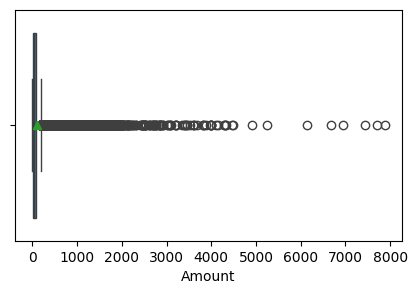

In [ ]:
#Boxplot variable age ( cest pr ls variables quantitattifs
plt.figure(figsize= (5 ,3 ))
sns.boxplot(data= df , x= "Amount", showmeans = True )
plt.show()

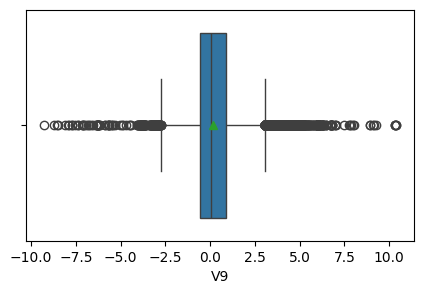

In [ ]:
#Boxplot variable V9
plt.figure(figsize= (5 ,3 ))
sns.boxplot(data= df , x= "V9", showmeans = True )
plt.show()

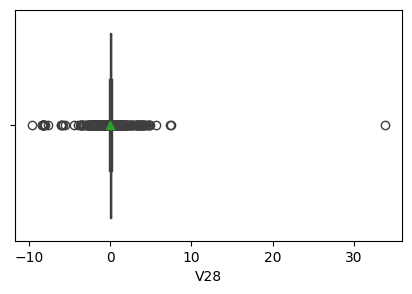

In [ ]:
#Boxplot variable V28
plt.figure(figsize= (5 ,3 ))
sns.boxplot(data= df , x= "V28", showmeans = True )
plt.show()

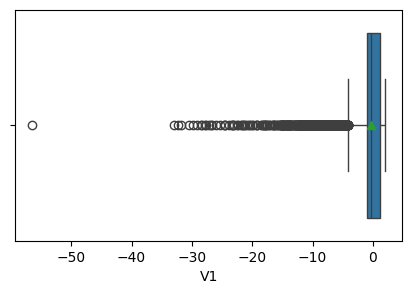

In [ ]:
#Boxplot variable V1
plt.figure(figsize= (5 ,3 ))
sns.boxplot(data= df , x= "V1", showmeans = True )
plt.show()

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,45646.0,27545.441331,12907.770469,0.000000,19891.000000,32447.000000,37571.750000,42437.000000
V1,45646.0,-0.237544,1.886548,-56.407510,-0.985248,-0.246259,1.157412,1.960497
V2,45646.0,0.028942,1.613070,-72.715728,-0.543868,0.088873,0.739723,18.183626
V3,45646.0,0.696718,1.530553,-32.965346,0.222804,0.801638,1.434911,4.101716
V4,45646.0,0.191505,1.403936,-5.172595,-0.714566,0.191835,1.070924,16.491217
V5,45646.0,-0.248407,1.414608,-42.147898,-0.853436,-0.280620,0.287608,34.801666
V6,45646.0,0.098573,1.308537,-26.160506,-0.638472,-0.155388,0.487528,22.529298
V7,45646.0,-0.117922,1.282808,-26.548144,-0.600049,-0.073139,0.429963,36.677268
V8,45646.0,0.053322,1.210491,-41.484823,-0.148364,0.054801,0.324343,20.007208
V9,45646.0,0.157869,1.222266,-9.283925,-0.589485,0.038300,0.859708,10.392889


### En résumé notre exploration de la base de donnees nous a permis de savoir que sur 100% seul 0,2% contiennent des donnees frauduleuses. Pour ne pas que notre modele soit mauvais , nous avons faire recours a d autres alternatives avant l'entrainement de nos donnees.

## Préparation des données

In [ ]:
#Copie de la base de donnees
data = df.copy()

In [ ]:
#Donnees manquantes
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
data.dtypes

Time        int32
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int32
dtype: object

In [ ]:
data.nunique()

Time      23476
V1        44628
V2        44628
V3        44628
V4        44628
V5        44628
V6        44628
V7        44628
V8        44628
V9        44628
V10       44628
V11       44628
V12       44628
V13       44628
V14       44628
V15       44628
V16       44628
V17       44628
V18       44628
V19       44628
V20       44628
V21       44628
V22       44628
V23       44628
V24       44628
V25       44628
V26       44628
V27       44628
V28       44628
Amount    11882
Class         2
dtype: int64

### Reechantillonage par  tirage aléatoire

In [ ]:
fraude = data[data['Class'] == 1]
non_fraude = data[data['Class'] == 0]

In [ ]:
# Suréchantillonnage de la classe minoritaire (fraude)
fraude_upsampled = resample(fraude,
                                replace=True,
                                n_samples=len(non_fraude),
                                random_state=42)

In [ ]:
# Fusion des classes frauduleuses suréchantillonnées avec les non frauduleuses
df_upsampled = pd.concat([non_fraude,fraude_upsampled])

In [ ]:
# Afficher les informations sur la répartition des classes
print(df_upsampled['Class'].value_counts())

Class
0    45504
1    45504
Name: count, dtype: int64


In [ ]:
df_upsampled.dtypes

Time        int32
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int32
dtype: object

 ###   En somme, nous avons choisi de faire un reechantillonnage car les donnees non fraudes étaient trop faible ce qui risquerais de biaiser notre modele. Parcontre nous n'avons pas touché aux données aberrantes car nous pensons que les variables ayant ces données tel que 'amount'peuvent potentiellement représenter des transactions frauduleuses.

# Entraînement du modèle à l'aide de Spark ML.

In [ ]:
# Convertir le DataFrame Pandas en un DataFrame Spark
df_upsampled_spark = spark.createDataFrame(df_upsampled)

In [ ]:
# Assembler les fonctionnalités dans une seule colonne "features"
feature_cols = df_upsampled_spark.columns[:-1]  # toutes les colonnes sauf la dernière (qui est la variable cible)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = assembler.transform(df_upsampled_spark)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = data_assembled.randomSplit([0.7, 0.3])

In [ ]:
# Entraîner le modèle de RandomForestClassifier
rf = RandomForestClassifier(labelCol="Class", featuresCol="features", numTrees=70)
rf_model = rf.fit(train_data)

In [ ]:
# Entraîner le modèle de Gradient Boosted Trees
gbt = GBTClassifier(labelCol="Class", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)

In [ ]:
# Évaluations des modèles sur les données de test
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

In [ ]:
# Affichage des prédictions
rf_predictions.show()
gbt_predictions.show()

+----+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------+-----+--------------------+--------------------+--------------------+----------+
|Time|                V1|                 V2|                 V3|                V4|                 V5|                 V6|                 V7|                 V8|                 V9|               V10|               V11|                V12|                V13|                V14|               V15|               V16|                V17|        

**Évaluation du modèle: évaluer la performance du modèle en utilisant des
métriques telles que la précision, le rappel et le F1-score.**


In [ ]:
# Création d un évaluateur pour la précision
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")

In [ ]:
# Calcule la précision pour RandomForest
accuracy_rf = evaluator.evaluate(rf_predictions)
print("Précision RandomForest :", accuracy_rf)

Précision RandomForest : 0.9924178908613713


In [ ]:
# Calcule la précision pour Gradient Boosted Trees
accuracy_gbt = evaluator.evaluate(gbt_predictions)
print("Précision Gradient Boosted Trees :", accuracy_gbt)

Précision Gradient Boosted Trees : 0.9965370174607225


In [ ]:
# Comparer les performances en termes de précision
if accuracy_rf > accuracy_gbt:
    print("RandomForest est plus performant en termes de précision.")
elif accuracy_rf < accuracy_gbt:
    print("Gradient Boosted Trees est plus performant en termes de précision.")
else:
    print("Les deux modèles ont la même précision.")

Gradient Boosted Trees est plus performant en termes de précision.


In [ ]:
# Création d un évaluateur pour le rappel
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")

In [ ]:
# Calcule du rappel pour RandomForest et Gradient Boosted Trees
recall_rf = evaluator.evaluate(rf_predictions)
print("Rappel RandomForest :", recall_rf)
recall_gbt = evaluator.evaluate(gbt_predictions)
print("Gradient Boosted Trees :", recall_gbt)

Rappel RandomForest : 0.9924178908613713
Gradient Boosted Trees : 0.9965370174607224


In [ ]:
# Création un évaluateur pour le F1-score
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")

In [ ]:
# Calcule du F1-score
f1_score_rf = evaluator.evaluate(rf_predictions)
print("F1-score  du rf :", f1_score_rf)
f1_score_gbt = evaluator.evaluate(gbt_predictions)
print("F1-score du gbt:", f1_score_gbt)

F1-score  du rf : 0.9924177025575696
F1-score du gbt: 0.9965369440173063


Nous avons choisi ces 2 modeles car ils sont robustes aux donnees mais apres l evaluation des modeles avec les metriques nous remarquons que notre modele avec Gradient Boosted Trees  est plus performant . Nous continuons avec ce modele.

**# Optimisation du modèle: explorer différentes approches pour améliorer les
performances du modèle, telles que la sélection de caractéristiques, le réglage
 des hyperparamètres et l'ensemble d'algorithmes.**

In [ ]:
from pyspark.ml.classification import  LogisticRegression, DecisionTreeClassifier

In [ ]:
#Définition des autres modèles
dt = DecisionTreeClassifier(labelCol="Class", featuresCol="features")
lr = LogisticRegression(labelCol="Class", featuresCol="features")

In [ ]:
# Définition des grilles d'hyperparamètres pour chaque modèle
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30, 40]) \
    .build()

param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

In [ ]:
# Combinaison des grilles d'hyperparamètres pour former un ensemble d'algorithmes
ensemble_param_grid = param_grid_dt + param_grid_lr

In [ ]:
# Affichage de l'ensemble des grilles d'hyperparamètres
for param_grid in ensemble_param_grid:
    print(param_grid)

{Param(parent='RandomForestClassifier_57820dbaff93', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_57820dbaff93', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5}
{Param(parent='RandomForestClassifier_57820dbaff93', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_57820dbaff93', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10}
{Param(parent='RandomForestClassifier_57820dbaff93', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_57820dbaff93', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 

In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [ ]:
cv_dt = CrossValidator(estimator=dt,
                       estimatorParamMaps=param_grid_dt,
                       evaluator=evaluator,
                       numFolds=5)

cv_lr = CrossValidator(estimator=lr,
                       estimatorParamMaps=param_grid_lr,
                       evaluator=evaluator,
                       numFolds=5)


**• Déploiement du modèle: déployer le modèle en utilisant Spark Streaming pour
la détection en temps réel de la fraude bancaire.**